In [2]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import Dataset,DataLoader
import torchvision.transforms as transforms
from  torchvision.datasets import ImageFolder
from torch.autograd import Variable
import cv2
import numpy as np
import os, random,sys


# Build a Variational Autoencoder (VAE) for a human face dataset

We will use a dataset containing images of people and train a variational autoencoder on it. 

## Step 1

Download and unzip the ``lfw.zip`` file . Adjust the ``path`` variable so that it contains the address of the unzipped folder. We will create a dataloader from this folder.


In [3]:
path = '/kaggle/input/imagedataset/lfw'

In [4]:
transform    = transforms.Compose([transforms.ToTensor()]) 
dataloader = DataLoader(ImageFolder(path, transform,),batch_size=32, shuffle=True)


This project is compute intensive. If you have a cuda or mps device on your laptop make sure you use that in the training.

In [5]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    print ("MPS device not found.")


MPS device not found.


torch.Size([250, 250, 3])


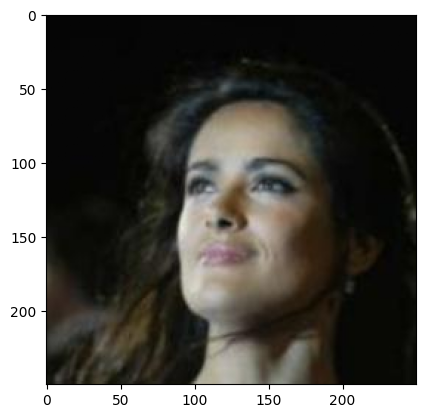

In [6]:
for x,y in dataloader:
    x = x[0].permute(1, 2, 0)
    print(x.shape)
    plt.imshow(x)
    break

# Step 2
The basis for this project is that you can alter your implementation of AutoEncoders from the previous homework and add the necessary bits for a VAE.  Clearly state what is the difference between AutoEncoders and VAEs in terms of Applications, Architecture and Loss function. 

Autoencoders (AEs) and Variational Autoencoders (VAEs) share a similar foundation, as VAEs are a specific type of autoencoder with added probabilistic elements. Here are the key differences between Autoencoders and Variational Autoencoders:

1. Applications:

Autoencoders (AEs):

--> AEs are primarily used for unsupervised learning tasks such as data compression, denoising, and feature learning.

--> They are effective for representation learning, where the model learns a compact and meaningful representation of input data.

Variational Autoencoders (VAEs):

--> VAEs extend the capabilities of AEs and are particularly well-suited for generating new samples by sampling from the learned latent space.

--> VAEs are commonly employed in generative modeling tasks, including image synthesis, style transfer, and data generation.

2. Architecture:

Autoencoders (AEs):

--> AEs consist of an encoder and a decoder.

--> The encoder maps the input data to a lower-dimensional latent space representation.

--> The decoder reconstructs the input data from this lower-dimensional representation.

--> AEs often have a bottleneck layer where the representation is compressed.

Variational Autoencoders (VAEs):

--> VAEs also have an encoder and a decoder, but they introduce a probabilistic approach to modeling the latent space.

--> Instead of producing a deterministic representation, the encoder outputs the mean and variance parameters of a probability distribution (usually Gaussian) in the latent space.

--> This introduces a stochastic element, enabling the generation of diverse samples.

3. Loss Function:

Autoencoders (AEs):

--> AEs typically use a reconstruction loss, such as Mean Squared Error (MSE), to measure the difference between the input and the reconstructed output.

--> The goal is to minimize the reconstruction loss to ensure faithful reconstruction.

Variational Autoencoders (VAEs):

--> VAEs use a combination of two terms in their loss function: a reconstruction loss and a regularization term (KL divergence).

--> The reconstruction loss is still present and measures the fidelity of the reconstructed output.

--> The KL divergence term encourages the learned latent space to follow a specific probabilistic distribution, often a unit Gaussian. This term helps regularize the latent space.


In summary, while both AEs and VAEs aim to learn efficient representations of input data, VAEs introduce probabilistic elements to the latent space, enabling more sophisticated generation tasks and providing a framework for sampling new data points. VAEs are particularly powerful in scenarios where generating new, diverse samples is a key requirement.

# Step 3

Update your pytorch autoencoder model class to create your VAE. Assume the encoder produces the mean and log variance of the latent space.  

**Create separate functions for the encoder and decoder.**

In [160]:
class VAE(nn.Module):
    
    def __init__(self):
        super(VAE,self).__init__()
        self.num_hidden = 32
        self.encoded_images = self.encoder()
        self.decoded_images = self.decoder()
        self.mu = nn.Linear(32, self.num_hidden)
        self.log_var = nn.Linear(32, self.num_hidden)
        

    def encoder(self):
        return nn.Sequential(nn.Conv2d(3, 8, kernel_size=3, stride=1, padding=1), 
                                 nn.BatchNorm2d(8),  
                                 nn.ReLU(True),  
                                 nn.MaxPool2d(2, stride=2),  
                                 
                                 nn.Conv2d(8, 16, kernel_size=3, stride=1, padding=1),  
                                 nn.BatchNorm2d(16), 
                                 nn.ReLU(True),  
                                 nn.MaxPool2d(2, stride=2),  
                                 
                                 nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=2),  
                                 nn.BatchNorm2d(32),  
                                 nn.ReLU(True),  
                                 nn.MaxPool2d(2, stride=2) 
                                ) 
        
    def decoder(self):
        return nn.Sequential(nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1),
                             nn.BatchNorm2d(16),
                             
                             nn.ConvTranspose2d(16,8, kernel_size=3, stride=2, padding=1),
                             nn.BatchNorm2d(8),
                             
                             nn.ConvTranspose2d(8, 3, kernel_size=3, stride=2, padding=1, output_padding=1),
                             nn.Tanh()
                            )
       
    def forward(self,x):
        # Pass the input through the encoder
        encoded = self.encoded_images(x)
        # Compute the mean and log variance vectors
        mu = self.mu(encoded)
        log_var = self.log_var(encoded)
        # Reparameterize the latent variable
        z = self.reparameterize(mu, log_var)
        # Pass the latent variable through the decoder
        decoded = self.decoded_images(z)
        # Return the encoded output, decoded output, mean, and log variance
        return encoded, decoded, mu, log_var
        
    
    
    def reparameterize(self, mu, log_var):
        # Compute the standard deviation from the log variance
        std = torch.exp(0.5 * log_var)
        # Generate random noise using the same shape as std
        eps = torch.randn_like(std)
        # Return the reparameterized sample
        return mu + eps * std


## Step 4
Create an instance of the new class, pass an image to the model

*  print the shape of the output of the **encoder**. Explain how would you generate new samples in the latent space. Your explanation should show that you have understood the concepts. Providing just the formula or code snippet without context will not earn any points.
*  use the decoder to create new images. Print the shape of the output and verify that the forward pass is working correctly. 

--> In a VAE, the latent space is modeled as a Gaussian distribution with a mean (mu) and a log variance (log_var). To generate new samples in the latent space, I can sample from this distribution. The reparameterization trick is employed, where a standard normal distribution is sampled (eps = torch.randn_like(std)) and then scaled and shifted using the mean and standard deviation obtained from the encoder.

--> Here are the steps to generate new samples in the latent space of a VAE:
1) Encode an Input Image: Pass an input image through the encoder to obtain the mean (μ) and log variance (log (σ^2 )) vectors.

2) Reparameterization Trick: z = μ + ϵ⋅σ, ϵ is standard normal distribution

3) Generate New Samples: The obtained z vector is a point in the latent space.

4) Decode to Generate Images: Pass the generated z vectors through the decoder to obtain corresponding generated images.

In [161]:
model = VAE()

In [162]:
data = iter(dataloader)
image,target = next(data)

encoded_output = model.encoded_images(image)
print(encoded_output.shape)
decoded_output = model.decoded_images(encoded_output)
print(decoded_output.shape)

torch.Size([32, 32, 32, 32])
torch.Size([32, 3, 250, 250])


In [171]:
# Dummy image tensor (replace this with your actual image tensor)
dummy_image = torch.randn(1, 3, 250, 250)

# Forward pass through the model
with torch.no_grad():
    encoded_output, decoded_output, mu, log_var = model.forward(dummy_image)

# Print the shape of the output of the encoder
print("Shape of the output of the encoder:", encoded_output.shape)

# Print the shape of the output of the decoder
print("Shape of the output of the decoder:", decoded_output.shape)

Shape of the output of the encoder: torch.Size([1, 32, 32, 32])
Shape of the output of the decoder: torch.Size([1, 3, 250, 250])


##  Step 5
* Print the total number of parameters in the model
* Explain what loss should be used here. Describe in your own words the terms of the loss function and what goal each term of the loss function achieves. Your explanation should show that you have understood the concepts. Providing just the formula or code snippet without context will not earn any points.


In a Variational Autoencoder (VAE), the loss function consists of two main terms: the reconstruction loss and the regularization term (KL divergence). By combining these terms, the VAE aims to balance the fidelity of reconstruction (reconstruction loss) with the regularization of the latent space (KL divergence), leading to a well-structured and generative latent space that can produce diverse and realistic samples during generation.

1. Reconstruction Loss:

--> Think of the reconstruction loss as a measure of how well the VAE is able to recreate the original input data. It's like asking the model, "Can you rebuild the picture of a cat from this fuzzy or incomplete image?" The goal is to make sure the recreated image looks as much like the original as possible.

2. Regularization Term (KL Divergence):

--> The regularization term, specifically KL divergence, is like a set of rules or guidelines for how the VAE should organize its thoughts about images in a special "thought space" (latent space). It ensures that this space follows specific rules, making it easier to create new and diverse images.

Imagine you have a collection of photos of cats, and you want to organize them in a way that makes it easy to come up with new, imaginary cat pictures. The regularization term helps ensure that your organization follows certain rules, like keeping similar-looking cats close together. This makes it simpler to imagine new cats by combining features from nearby ones.

Overall, This integration enables the VAE to learn a meaningful and well-organized latent representation, facilitating both accurate reconstructions and the generation of diverse and realistic samples in a controlled latent space.

In [ ]:
loss_function = nn.MSELoss()

In [164]:
total_parameters = sum(params.numel() for params in model.parameters())
print(total_parameters)

14307


* create an optimizer for training

In [165]:
optim = torch.optim.Adam(model.parameters(), lr=0.001)

##  Step 6
Write a training loop and start training the model for several epochs. Report the loss value at the end of each epoch and monitor it. If your loss is not decreasing what do you have to do to troubleshoot it ?

If the loss in your training process is not decreasing as expected, it's essential to troubleshoot and identify potential issues. Here are some common troubleshooting steps:

1) Learning Rate Adjustment:
Check the learning rate used for training. If it is too high, the optimization process might be overshooting the optimal values. Conversely, if it is too low, the model might converge very slowly. Adjust the learning rate and observe the impact on the loss.

2) Check for Overfitting: 
Monitoring both training and validation loss helps identify overfitting. If the training loss decreases, but the validation loss increases, the model may be overfitting the training data. Regularization techniques or dropout can mitigate overfitting.

3) Adjust Batch Size:
Batch size influences the weight updates during training. Different batch sizes may impact convergence behavior. Adjusting the batch size allows you to find a suitable configuration for your specific model and data.

4) Evaluate Different Architectures:
Experimenting with different model architectures or variations can reveal which structure is more suitable for your specific task. Adjusting the model architecture might lead to improved convergence.

This are the few ways on troubleshooting the loss.

In [ ]:
# Training loop
num_epochs = 300
for epoch in range(num_epochs):
    total_loss = 0.0
    i = 0
    for x,y in dataloader:
        # Get a batch of training data and move it to the device
        #data = data.to(device)

        # Forward pass
        encoded, decoded, mu, log_var = model(x)

        # Compute the loss and perform backpropagation
        KLD = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
        loss = loss_function(decoded, x) + 3 * KLD
        optim.zero_grad()
        loss.backward()
        optim.step()

        # Update the running loss
        total_loss += loss.item() * x.size(0)
        i += 1
        break;
    # Print the epoch loss
    epoch_loss = total_loss 
    print(
        "Epoch {}/{}: loss={:.4f}".format(epoch + 1, num_epochs, epoch_loss)
    )

##  Step 7

Take a random image from the dataset and plot it together with new samples generated.

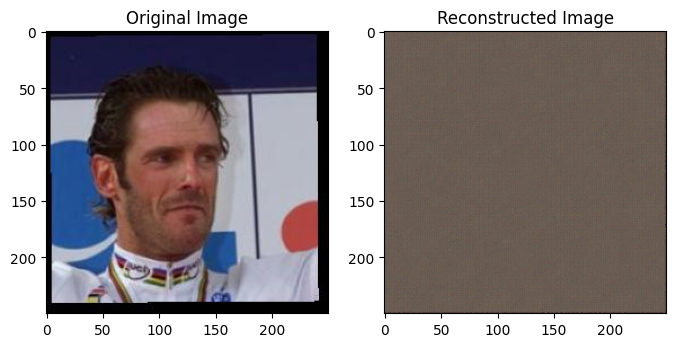

In [168]:
data = iter(dataloader)
image,target = next(data)
original_image = image[6]

# Forward pass through the model
with torch.no_grad():
    _,reconstructed_image,_,_ = model(original_image.unsqueeze(0))  # Add an extra dimension for batch size

# Convert tensors to numpy arrays for visualization
original_image_np = original_image.permute(1, 2, 0).cpu().numpy()
reconstructed_image_np = reconstructed_image.squeeze(0).permute(1, 2, 0).cpu().numpy()

# Plot the original and reconstructed images side by side
fig, axes = plt.subplots(1, 2, figsize=(8, 4))
axes[0].imshow(original_image_np)
axes[0].set_title('Original Image')

axes[1].imshow(reconstructed_image_np)
axes[1].set_title('Reconstructed Image')

plt.show()